In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/corona-virus-report/usa_county_wise.csv
/kaggle/input/corona-virus-report/covid_19_clean_complete.csv
/kaggle/input/population-by-country-2020/population_by_country_2020.csv
/kaggle/input/covid19-global-forecasting-week-4/submission.csv
/kaggle/input/covid19-global-forecasting-week-4/test.csv
/kaggle/input/covid19-global-forecasting-week-4/train.csv
/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv


In [87]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
import datetime
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')


In [88]:
#reading the data set
#test = pd.read_csv('../input/covid19-global-forecasting-week-2/test.csv')
#train = pd.read_csv('../input/covid19-global-forecasting-week-2/train.csv')
test = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
df_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
covid_pop = pd.read_csv('../input/covid19-global-forecasting-locations-population/locations_population.csv')

## exploring the data set

In [89]:
display(train.describe())
display(train.tail(5))
display(train.shape)
train[['Province_State','Country_Region','Date']].describe()

Id  ConfirmedCases    Fatalities
count  25979.000000    25979.000000  25979.000000
mean   17826.000000     1128.434851     58.169252
std    10300.679697     8252.496072    660.659625
min        1.000000        0.000000      0.000000
25%     8913.500000        0.000000      0.000000
50%    17826.000000        1.000000      0.000000
75%    26738.500000      108.000000      1.000000
max    35651.000000   195749.000000  20465.000000

Id Province_State Country_Region        Date  ConfirmedCases  \
25974  35647            NaN       Zimbabwe  2020-04-09            11.0   
25975  35648            NaN       Zimbabwe  2020-04-10            13.0   
25976  35649            NaN       Zimbabwe  2020-04-11            14.0   
25977  35650            NaN       Zimbabwe  2020-04-12            14.0   
25978  35651            NaN       Zimbabwe  2020-04-13            17.0   

       Fatalities  
25974         3.0  
25975         3.0  
25976         3.0  
25977         3.0  
25978         3.0

(25979, 6)

Province_State Country_Region        Date
count           11039          25979       25979
unique            133            184          83
top           Alabama             US  2020-02-10
freq               83           4482         313

In [90]:
print("Max Date: ", max(train['Date']), ", Min Date: ", min(train['Date']))
print("Max Id: ", max(train['Id']), ", Unique Ids: ", train['Id'].nunique())
print("Max Date: ", max(test['Date']), ", Min Date: ", min(test['Date']))

Max Date:  2020-04-13 , Min Date:  2020-01-22
Max Id:  35651 , Unique Ids:  25979
Max Date:  2020-05-14 , Min Date:  2020-04-02


In [91]:
train.isnull().sum()

Id                    0
Province_State    14940
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

> *Data Set Summary (this should be updated on the day you run this as the data set is live )*
* size of the data set : 19404, 6
* 173 unique countries
* 125 unique Provice_states (11154 null records)
* data for 66 days from 22-Jan-2020 to 27-Mar-2020

## Exploratory Analysis starts from here

In [92]:
#plotting the daily trend
ww_df = train.groupby('Date')[['ConfirmedCases', 'Fatalities']].sum().reset_index()
# shift is used to take the previous value
ww_df['New_Cases'] = ww_df['ConfirmedCases'] - ww_df['ConfirmedCases'].shift(1)
#ww_df.tail()
#pd.melt is used to create a simillar table like a pivot in excel

trend_df = pd.melt(ww_df, id_vars=['Date'], value_vars=['ConfirmedCases', 'Fatalities', 'New_Cases'])
trend_df.head(5)

fig = px.line(trend_df, x="Date", y="value", color='variable', title="Worldwide Confirmed/Death trend")
fig.show()

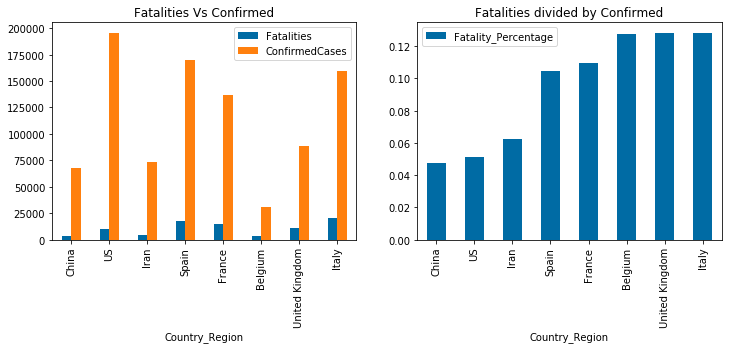

In [93]:
plt.style.use(['tableau-colorblind10'])

#plotting the top 8 Countries with most Fatalities as per latest day

df_Country = train.groupby(['Country_Region'])[["Fatalities","ConfirmedCases"]].max().nlargest(8,'Fatalities')
#df_Country = train[train['Date']=='2020-03-31'].groupby(['Country_Region'])[["Fatalities","ConfirmedCases"]].sum().nlargest(8,'Fatalities')
#bycountry = train.groupby('Country_Region')['Fatalities'].max().sort_values(ascending=False).to_frame().reset_index()

#fatality % = Fatality_Count / Confirmed_Count

df_Country['Fatality_Percentage'] = df_Country['Fatalities']/ df_Country['ConfirmedCases']
df_Country = df_Country.reset_index()
df_Country.sort_values('Fatality_Percentage',inplace=True)
figure, axes = plt.subplots(1, 2,figsize=(12,4))
df_Country.plot(ax= axes[0],x = 'Country_Region', y = ["Fatalities","ConfirmedCases"],kind='bar', title = 'Fatalities Vs Confirmed')
df_Country.plot(ax= axes[1],x = 'Country_Region', y = ["Fatality_Percentage"],kind='bar', title = 'Fatalities divided by Confirmed')

Need to check how rapidly Fatalities are happenning in each country. For this I got the First Fatal Date, Last Fatal Date. The difference between those 2 values give us the no.of the days the country has been in the Fatality Status. Dividing the Fatal count by this number of Fatal Days give the fatal rate.

In [94]:
#getting the dates with at least 1 Fatality and atleast 1 confirmed case separately
cond1 = train.Fatalities >=1
cond2 = train.ConfirmedCases >= 1
train_Fatal = train[['Country_Region','Date']][(cond1)]
train_Confirm = train[['Country_Region','Date']][(cond2)]

#getting the 1st Confirmed case date for each country
Confirm_Min_Max = train_Confirm.groupby("Country_Region", as_index=False)["Date"].agg(["min","max"])

#getting the 1st Fatality date for each country
Fatal_Min_Max = train_Fatal.groupby("Country_Region", as_index=False)["Date"].agg(["min","max"])

#left outer join the above 2 dataFrames

Country_Dates = pd.merge(Confirm_Min_Max, Fatal_Min_Max, how='left', on=['Country_Region'])
Country_Dates = Country_Dates.rename(columns={'min_x': 'fst_Confirmed', 'max_x': 'last_Confirmed', 'min_y': 'fst_Fatal','max_y': 'last_Fatal'})
    
#setting a default date for null date values
#should remove null day count to get fatality rate (to avoid Division with nulls)

#Date_Cols = ['fst_Confirmed','last_Confirmed','fst_Fatal','last_Fatal']

#Country_Dates[Date_Cols] = Country_Dates[Date_Cols].fillna(pd.to_datetime('2015-01-01'))

Country_Dates['Fatality_Days'] = pd.to_datetime(Country_Dates['last_Fatal']) - pd.to_datetime(Country_Dates['fst_Fatal'])
Country_Dates = Country_Dates.reset_index()
#Country_Dates.head(5)

In [95]:
# converting date counts to integer values

Country_Dates['Fatality_Days'] = Country_Dates['Fatality_Days'] / np.timedelta64(1, 'D')

Country_Dates.head(5)

Country_Region fst_Confirmed last_Confirmed   fst_Fatal  last_Fatal  \
0    Afghanistan    2020-02-24     2020-04-13  2020-03-22  2020-04-13   
1        Albania    2020-03-09     2020-04-13  2020-03-11  2020-04-13   
2        Algeria    2020-02-25     2020-04-13  2020-03-12  2020-04-13   
3        Andorra    2020-03-02     2020-04-13  2020-03-22  2020-04-13   
4         Angola    2020-03-20     2020-04-13  2020-03-29  2020-04-13   

   Fatality_Days  
0           22.0  
1           33.0  
2           32.0  
3           22.0  
4           15.0

In [96]:
#consider the country wise fatalities and Confirmed cases

#Country_Counts = train.groupby(['Country_Region'])[["Fatalities","ConfirmedCases"]].sum()
cond1 = train.Date == '2020-04-12'
Country_Counts = train[['Country_Region','Date','Fatalities','ConfirmedCases']][(cond1)]
#Country_Counts = train[train['Date']=='2020-03-31']
#Getting min max dates and counts grouped by country

df_Country2 = pd.merge(Country_Dates, Country_Counts, how='left', on=['Country_Region'])

df_Country2['Fatality_Rate'] = round(df_Country2['Fatalities']/pd.to_numeric(df_Country2['Fatality_Days']),2)
df_Country2['Fatality_Rate'] = round(df_Country2['Fatalities']/pd.to_numeric(df_Country2['Fatality_Days']),2)

#null fatality rates are set as 0
#infinity fatality rates are set as NaN

df_Country2['Fatality_Rate'] = df_Country2['Fatality_Rate'].fillna(0)
df_Country2 = df_Country2.replace([np.inf, -np.inf], np.nan)
#df_Country2['Country_Region'].describe()

#top 8 countries with the largest Fatality Rates

df_Country3 = df_Country2[df_Country2['Fatality_Rate'] > 0].groupby(['Country_Region'])[["Fatality_Rate"]].sum().nlargest(8,'Fatality_Rate')
df_Country3 = df_Country3.reset_index()

Following chart shows the average increment of the fatality count for a day from the 1st fatality identified date

In [97]:
#df_Country3.head(5)
#df_Country3.plot(x='Country_Region', y= ["Fatality_Rate"], kind = 'bar', title = 'Top 8 countries with largest fatality rate (Fatalities/Day)')

fig = px.bar(df_Country3, x='Country_Region', y='Fatality_Rate',color='Fatality_Rate')
fig.show()

Looking at the above plots, I categorized the countries in to following groups.
* China - As the first outbreak happened in China, this is an exceptional case. Need to be studies separately
* Italy, Spain, USA, France - These are the top 4 countries affected when considered both the Fatality rate, (Fatalities/ Confirmed) rate.
* Netherlands, Iran, UK - These are the remaining countries from the top 8 affected
* Other Countries

### Plotting the Confirmed vs Fatalities trend for top 8 countries

In [98]:
confirmed_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_China = confirmed_China.join(fatalities_China)

confirmed_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Italy = confirmed_Italy.join(fatalities_Italy)

confirmed_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Spain = confirmed_Spain.join(fatalities_Spain)

confirmed_Iran = train[train['Country_Region']=='Iran'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Iran = train[train['Country_Region']=='Iran'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Iran = confirmed_Iran.join(fatalities_Iran)

confirmed_France = train[train['Country_Region']=='France'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_France = train[train['Country_Region']=='France'].groupby(['Date']).agg({'Fatalities':['sum']})
total_France = confirmed_France.join(fatalities_France)

confirmed_Netherlands = train[train['Country_Region']=='Netherlands'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Netherlands = train[train['Country_Region']=='Netherlands'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Netherlands = confirmed_Netherlands.join(fatalities_Netherlands)

confirmed_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_UK = confirmed_UK.join(fatalities_UK)

confirmed_USA = train[train['Country_Region']=='US'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_USA = train[train['Country_Region']=='US'].groupby(['Date']).agg({'Fatalities':['sum']})
total_USA = confirmed_USA.join(fatalities_USA)


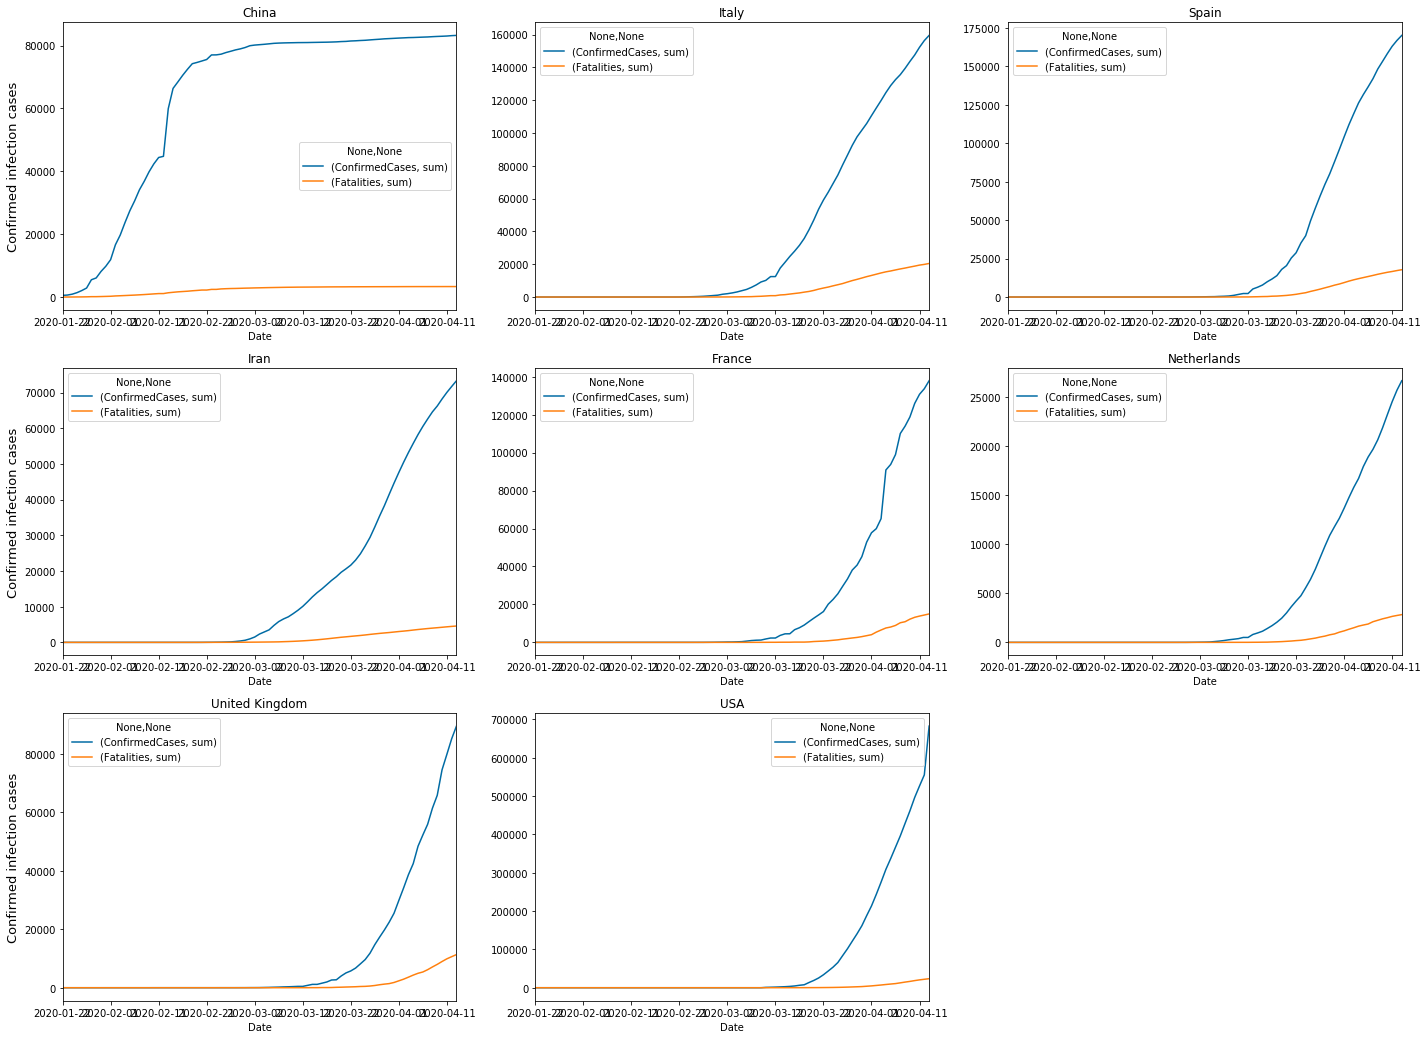

In [99]:
plt.figure(figsize=(24,18))

plt.subplot(3, 3, 1)
total_China.plot(ax=plt.gca(), title='China')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(3, 3, 2)
total_Italy.plot(ax=plt.gca(), title='Italy')

plt.subplot(3, 3, 3)
total_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(3, 3, 4)
total_Iran.plot(ax=plt.gca(), title='Iran')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(3, 3, 5)
total_France.plot(ax=plt.gca(), title='France')

plt.subplot(3, 3, 6)
total_Netherlands.plot(ax=plt.gca(), title='Netherlands')

plt.subplot(3, 3, 7)
total_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(3, 3, 8)
total_USA.plot(ax=plt.gca(), title='USA')

**Observations**
* Above graphs clearly shows that the trend in China is different from the other countries
* All the other countries shows a likely trend. However, considering the slopes of the graphs from visual level it can be oberved that USA is having a higher rate of Confirmed cases over a small time period
* While other countries have gone to the ( I would call it "Red Zone" ) in a regular way ( Confirmed cases have gradually increased ), Iran has entered the "Red Zone" directly. It shows a sudden increment on confirmed cases.

### Population wise, Land Area wise, Urban Population wise, Median Age wise fatality rate and confirmed rate

when going through articles about COVID - 19, following factors in a country was found as factors that are having an impact on COVID-19 outbreak in a country
* Population density
* Age of the infected person
* Urban population - These areas are highly populated with people and high urban population may affect to a high spread 

In [100]:
#selecting only the needed columns from population 
#df_pop.columns
df_pop_sel = df_pop[['Country (or dependency)','Population (2020)','Density (P/Km²)','Land Area (Km²)','Med. Age','Urban Pop %']]

#renaming the columns
df_pop_sel.columns = ['Country_Region', 'Population (2020)', 'Density (P/Km²)','Land Area (Km²)', 'Med. Age', 'Urban Pop %']

# Remove the % sign from Urban Pop % field
df_pop_sel['Urban Pop %'] = df_pop_sel['Urban Pop %'].str.rstrip('%')

# Replace United States by US
df_pop_sel.loc[df_pop_sel['Country_Region']=='United States', 'Country_Region'] = 'US'

df_country_pop = pd.merge(df_pop_sel, df_Country, how='inner', on=['Country_Region'])
df_country_pop

Country_Region  Population (2020)  Density (P/Km²)  Land Area (Km²)  \
0           China         1438116346              153          9388211   
1              US          330578810               36          9147420   
2            Iran           83753963               52          1628550   
3  United Kingdom           67808264              281           241930   
4          France           65242267              119           547557   
5           Italy           60480876              206           294140   
6           Spain           46750879               94           498800   
7         Belgium           11578652              383            30280   

  Med. Age Urban Pop %  Fatalities  ConfirmedCases  Fatality_Percentage  
0       38         61       3221.0         67803.0             0.047505  
1       38         83      10058.0        195749.0             0.051382  
2       32         76       4585.0         73303.0             0.062549  
3       40         83      11329.0         88621.0             0.127837  
4       42         82      14967.0        136779.0             0.109425  
5       47         69      20465.0        159516.0             0.128294  
6       45         80      17756.0        170099.0             0.104386  
7       42         98       3903.0         30589.0             0.127595

Let's create the following factors to get an idea about the affect from Population, Population Density, Median Age, Urban population %
* pop_factor - considering the population (Fatalities/ Population) : larger value, larger impact
* Density_factor - considering the population density : 
* age_factor - considering the Median Age
* urban_factor - considering the urban population

I will use only the population factor for demonstration

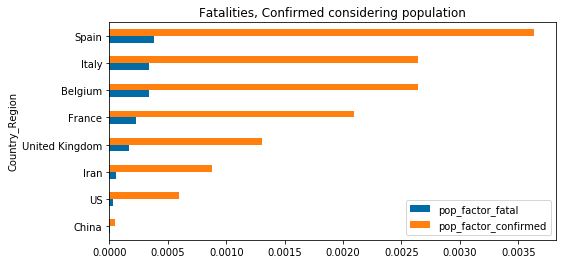

In [101]:
df_country_pop["pop_factor_fatal"] = df_country_pop['Fatalities']/df_country_pop['Population (2020)']
df_country_pop["pop_factor_confirmed"] = df_country_pop['ConfirmedCases']/df_country_pop['Population (2020)']
#df_country_pop = df_country_pop.reset_index(drop = True)
df_country_pop.sort_values('pop_factor_fatal',inplace=True)
df_country_pop
df_country_pop.plot(x = 'Country_Region', y = ["pop_factor_fatal","pop_factor_confirmed"],kind='barh', title = 'Fatalities, Confirmed considering population',figsize = (8,4))

### Insights from the EDA ( Exploratory Data Analysis ) as recorded on 4th April 2020

* Confirmed, Fatal and New Counts still shows a upward trend and increasing day by day.
* USA shows the highest confirmed count.
* Italy shows the highest fatal count.
* Italy shows the highest ratio between Fatalities and Confirmed Cases.
* Italy, Spain , USA, France are the top 4 countires with highest fatal rates. Fatal rate is the fatal count per day from the first identified fatal case of that country.
* China's trend is different with the daily trends ( Confirmed and Fatal ) of other countries. This may be becuase the outbreak started and recorded first in China. Therefore, in the modelling part China should be considered separately.
* Italy and Spain have a significant fatal count and a confirmed count when compaired with their population

## Cleansing the data set

In [102]:
# filtering data before 26th March as for the competition rules for prediction

cond1 = train['Date'] < '2020-04-01'
train_fil = train[(cond1)]
display(train_fil['Date'].max())
display(train_fil['Date'].min())

'2020-03-31'

'2020-01-22'

In [103]:
display(train_fil.head(5))
display(covid_pop.head(5))

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

Province.State       Country.Region  Population Provenance
0            NaN          Afghanistan    35530000        NaN
1            NaN              Albania     2877000        NaN
2            NaN              Algeria    41320000        NaN
3            NaN              Andorra       78000        NaN
4            NaN  Antigua and Barbuda      102012        NaN

In [104]:
#preprocessing

train_fil['Date'] = pd.to_datetime(train_fil['Date'])
train_fil['Day_num'] = preprocessing.LabelEncoder().fit_transform(train_fil.Date)
train_fil['Day'] = train_fil['Date'].dt.day
train_fil['Month'] = train_fil['Date'].dt.month
train_fil['Year'] = train_fil['Date'].dt.year

train_fil_copy = train_fil

train_fil['Province_State'].fillna("None", inplace=True)

#Checking null values
train_fil[train_fil.iloc[:,0:].isnull().any(axis = 1)].iloc[:,0:].head()

Empty DataFrame
Columns: [Id, Province_State, Country_Region, Date, ConfirmedCases, Fatalities, Day_num, Day, Month, Year]
Index: []

In [105]:
# there is a new data set uploaded for population details for covid data set. I am using this for the population data

covid_pop_sel = covid_pop[['Province.State','Country.Region','Population']]
covid_pop_sel['Province.State'].fillna("None", inplace=True)

#Checking null values
covid_pop_sel[covid_pop_sel.iloc[:,0:].isnull().any(axis = 1)].iloc[:,0:].head()

Empty DataFrame
Columns: [Province.State, Country.Region, Population]
Index: []

In [106]:
#joining population details as previously done in EDA

df_train_pop = train_fil.merge(covid_pop_sel, left_on = ['Country_Region','Province_State'], right_on = ['Country.Region','Province.State'], how = 'left')
#df_train_pop[df_train_pop.iloc[:,1:].isnull().any(axis = 1)].iloc[:,1:].head(3)

In [107]:
display(covid_pop_sel[covid_pop_sel['Country.Region']=='Italy'])
display(train_fil[train_fil['Country_Region']=='Italy'])

Province.State Country.Region  Population
158           None          Italy    60480000

Id Province_State Country_Region       Date  ConfirmedCases  \
12118  16645           None          Italy 2020-01-22             0.0   
12119  16646           None          Italy 2020-01-23             0.0   
12120  16647           None          Italy 2020-01-24             0.0   
12121  16648           None          Italy 2020-01-25             0.0   
12122  16649           None          Italy 2020-01-26             0.0   
...      ...            ...            ...        ...             ...   
12183  16710           None          Italy 2020-03-27         86498.0   
12184  16711           None          Italy 2020-03-28         92472.0   
12185  16712           None          Italy 2020-03-29         97689.0   
12186  16713           None          Italy 2020-03-30        101739.0   
12187  16714           None          Italy 2020-03-31        105792.0   

       Fatalities  Day_num  Day  Month  Year  
12118         0.0        0   22      1  2020  
12119         0.0        1   23      1  2020  
12120         0.0        2   24      1  2020  
12121         0.0        3   25      1  2020  
12122         0.0        4   26      1  2020  
...           ...      ...  ...    ...   ...  
12183      9134.0       65   27      3  2020  
12184     10023.0       66   28      3  2020  
12185     10779.0       67   29      3  2020  
12186     11591.0       68   30      3  2020  
12187     12428.0       69   31      3  2020  

[70 rows x 10 columns]

In [108]:
#getting Country_Regions with Null population (These have not joined correctly when used the primary key as Country_Region)
#check = df_train_pop[df_train_pop['Country_Region']=='Canada'][df_train_pop['Population'].isnull()]
df_train_pop['Province_State'][df_train_pop['Population'].isnull()].unique()
df_train_pop.reindex()
#check[check['Date']=='2020-03-25']

Id Province_State Country_Region       Date  ConfirmedCases  \
0          1           None    Afghanistan 2020-01-22             0.0   
1          2           None    Afghanistan 2020-01-23             0.0   
2          3           None    Afghanistan 2020-01-24             0.0   
3          4           None    Afghanistan 2020-01-25             0.0   
4          5           None    Afghanistan 2020-01-26             0.0   
...      ...            ...            ...        ...             ...   
21905  35634           None       Zimbabwe 2020-03-27             5.0   
21906  35635           None       Zimbabwe 2020-03-28             7.0   
21907  35636           None       Zimbabwe 2020-03-29             7.0   
21908  35637           None       Zimbabwe 2020-03-30             7.0   
21909  35638           None       Zimbabwe 2020-03-31             8.0   

       Fatalities  Day_num  Day  Month  Year Province.State Country.Region  \
0             0.0        0   22      1  2020           None    Afghanistan   
1             0.0        1   23      1  2020           None    Afghanistan   
2             0.0        2   24      1  2020           None    Afghanistan   
3             0.0        3   25      1  2020           None    Afghanistan   
4             0.0        4   26      1  2020           None    Afghanistan   
...           ...      ...  ...    ...   ...            ...            ...   
21905         1.0       65   27      3  2020           None       Zimbabwe   
21906         1.0       66   28      3  2020           None       Zimbabwe   
21907         1.0       67   29      3  2020           None       Zimbabwe   
21908         1.0       68   30      3  2020           None       Zimbabwe   
21909         1.0       69   31      3  2020           None       Zimbabwe   

       Population  
0        35530000  
1        35530000  
2        35530000  
3        35530000  
4        35530000  
...           ...  
21905    16530000  
21906    16530000  
21907    16530000  
21908    16530000  
21909    16530000  

[21910 rows x 13 columns]

In [109]:
#code to check column wise null count
#pd.DataFrame(population_raw.isnull().sum()).T

#wildcard matching 
#df_pop_sel[df_pop_sel['Country_Region'].str.match('Taiwan')]

In [110]:
# Replace Country names to match the train data set
#df_pop_sel.loc[df_pop_sel['Country_Region']=='Czech Republic (Czechia)', 'Country_Region'] = 'Czechia'
#df_pop_sel.loc[df_pop_sel['Country_Region']=='Taiwan', 'Country_Region'] = 'Taiwan*'

In [111]:
#merging the data set again, after mapping the country names
#df_train_pop = train_fil.merge(df_pop_sel, left_on = 'Country_Region', right_on = 'Country_Region', how = 'left')
#df_train_pop[df_train_pop.iloc[:,1:].isnull().any(axis = 1)].iloc[:,1:].head(3)

In [112]:
df_train_pop[df_train_pop.iloc[:,1:].isnull().any(axis = 1)].iloc[:,1:].head(3)

Empty DataFrame
Columns: [Province_State, Country_Region, Date, ConfirmedCases, Fatalities, Day_num, Day, Month, Year, Province.State, Country.Region, Population]
Index: []

In [113]:
#treating null values
df_train_pop['Province.State'].fillna("None", inplace=True)
df_train_pop['Country.Region'].fillna("None", inplace=True)
df_train_pop['Population'] = df_train_pop['Population'].fillna(0)

In [114]:
#df_train_pop[['Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']] = df_train_pop[['Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']].fillna(0)

In [115]:
missings_count = {col:df_train_pop[col].isnull().sum() for col in df_train_pop.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
Day_num         0
Day             0
Month           0
Year            0
Province.State  0
Country.Region  0
Population      0


## Developing the model

EDA gives us some clear insights and a better understanding about the dataset. Therefore a better EDA should be done before directly moving to the modelling part. 
Here is how I started with my model...

As this is an epidemic, I searched what are the statistical models used for forecasting in epidemics. I have attached some links that I found useful to understand an epidemic on a statistical background.

* [https://www.sciencedirect.com/science/article/pii/S1755436516300329](http://)
* [https://www.universiteitleiden.nl/binaries/content/assets/science/mi/scripties/statscience/2017-2018/2018_06_29_masterthesis_verkerk.pdf](http://)
* [https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006917](http://)

I found this very interesing visualization for past pandemics.

* https://www.visualcapitalist.com/history-of-pandemics-deadliest/

Some models Used in forecasting epidemics :

* autoregressive integrated moving average (ARIMA) model - accurate only short-term prediction
* generalized linear model (GLM)
* SIR (Susceptible – Infected – Removed) model
* SEIR (Susceptible – Exposed - Infected – Removed) model

## SIR Model

This is a mostly used model to study the behaviour of an epidemic. 
* **S - Susceptible** is a group of people who are vulnerable to exposure with infectious people. They can be patient when the infection happens
* **I - infectious** represents the infected people
* **R - Recovered/ Removed** people get immunity so that they are not susceptible to the same illness anymore

This Model has some extended versions of it like SEIR (Cossidering the Exposed population) and SIRD (Considering the Deaths)

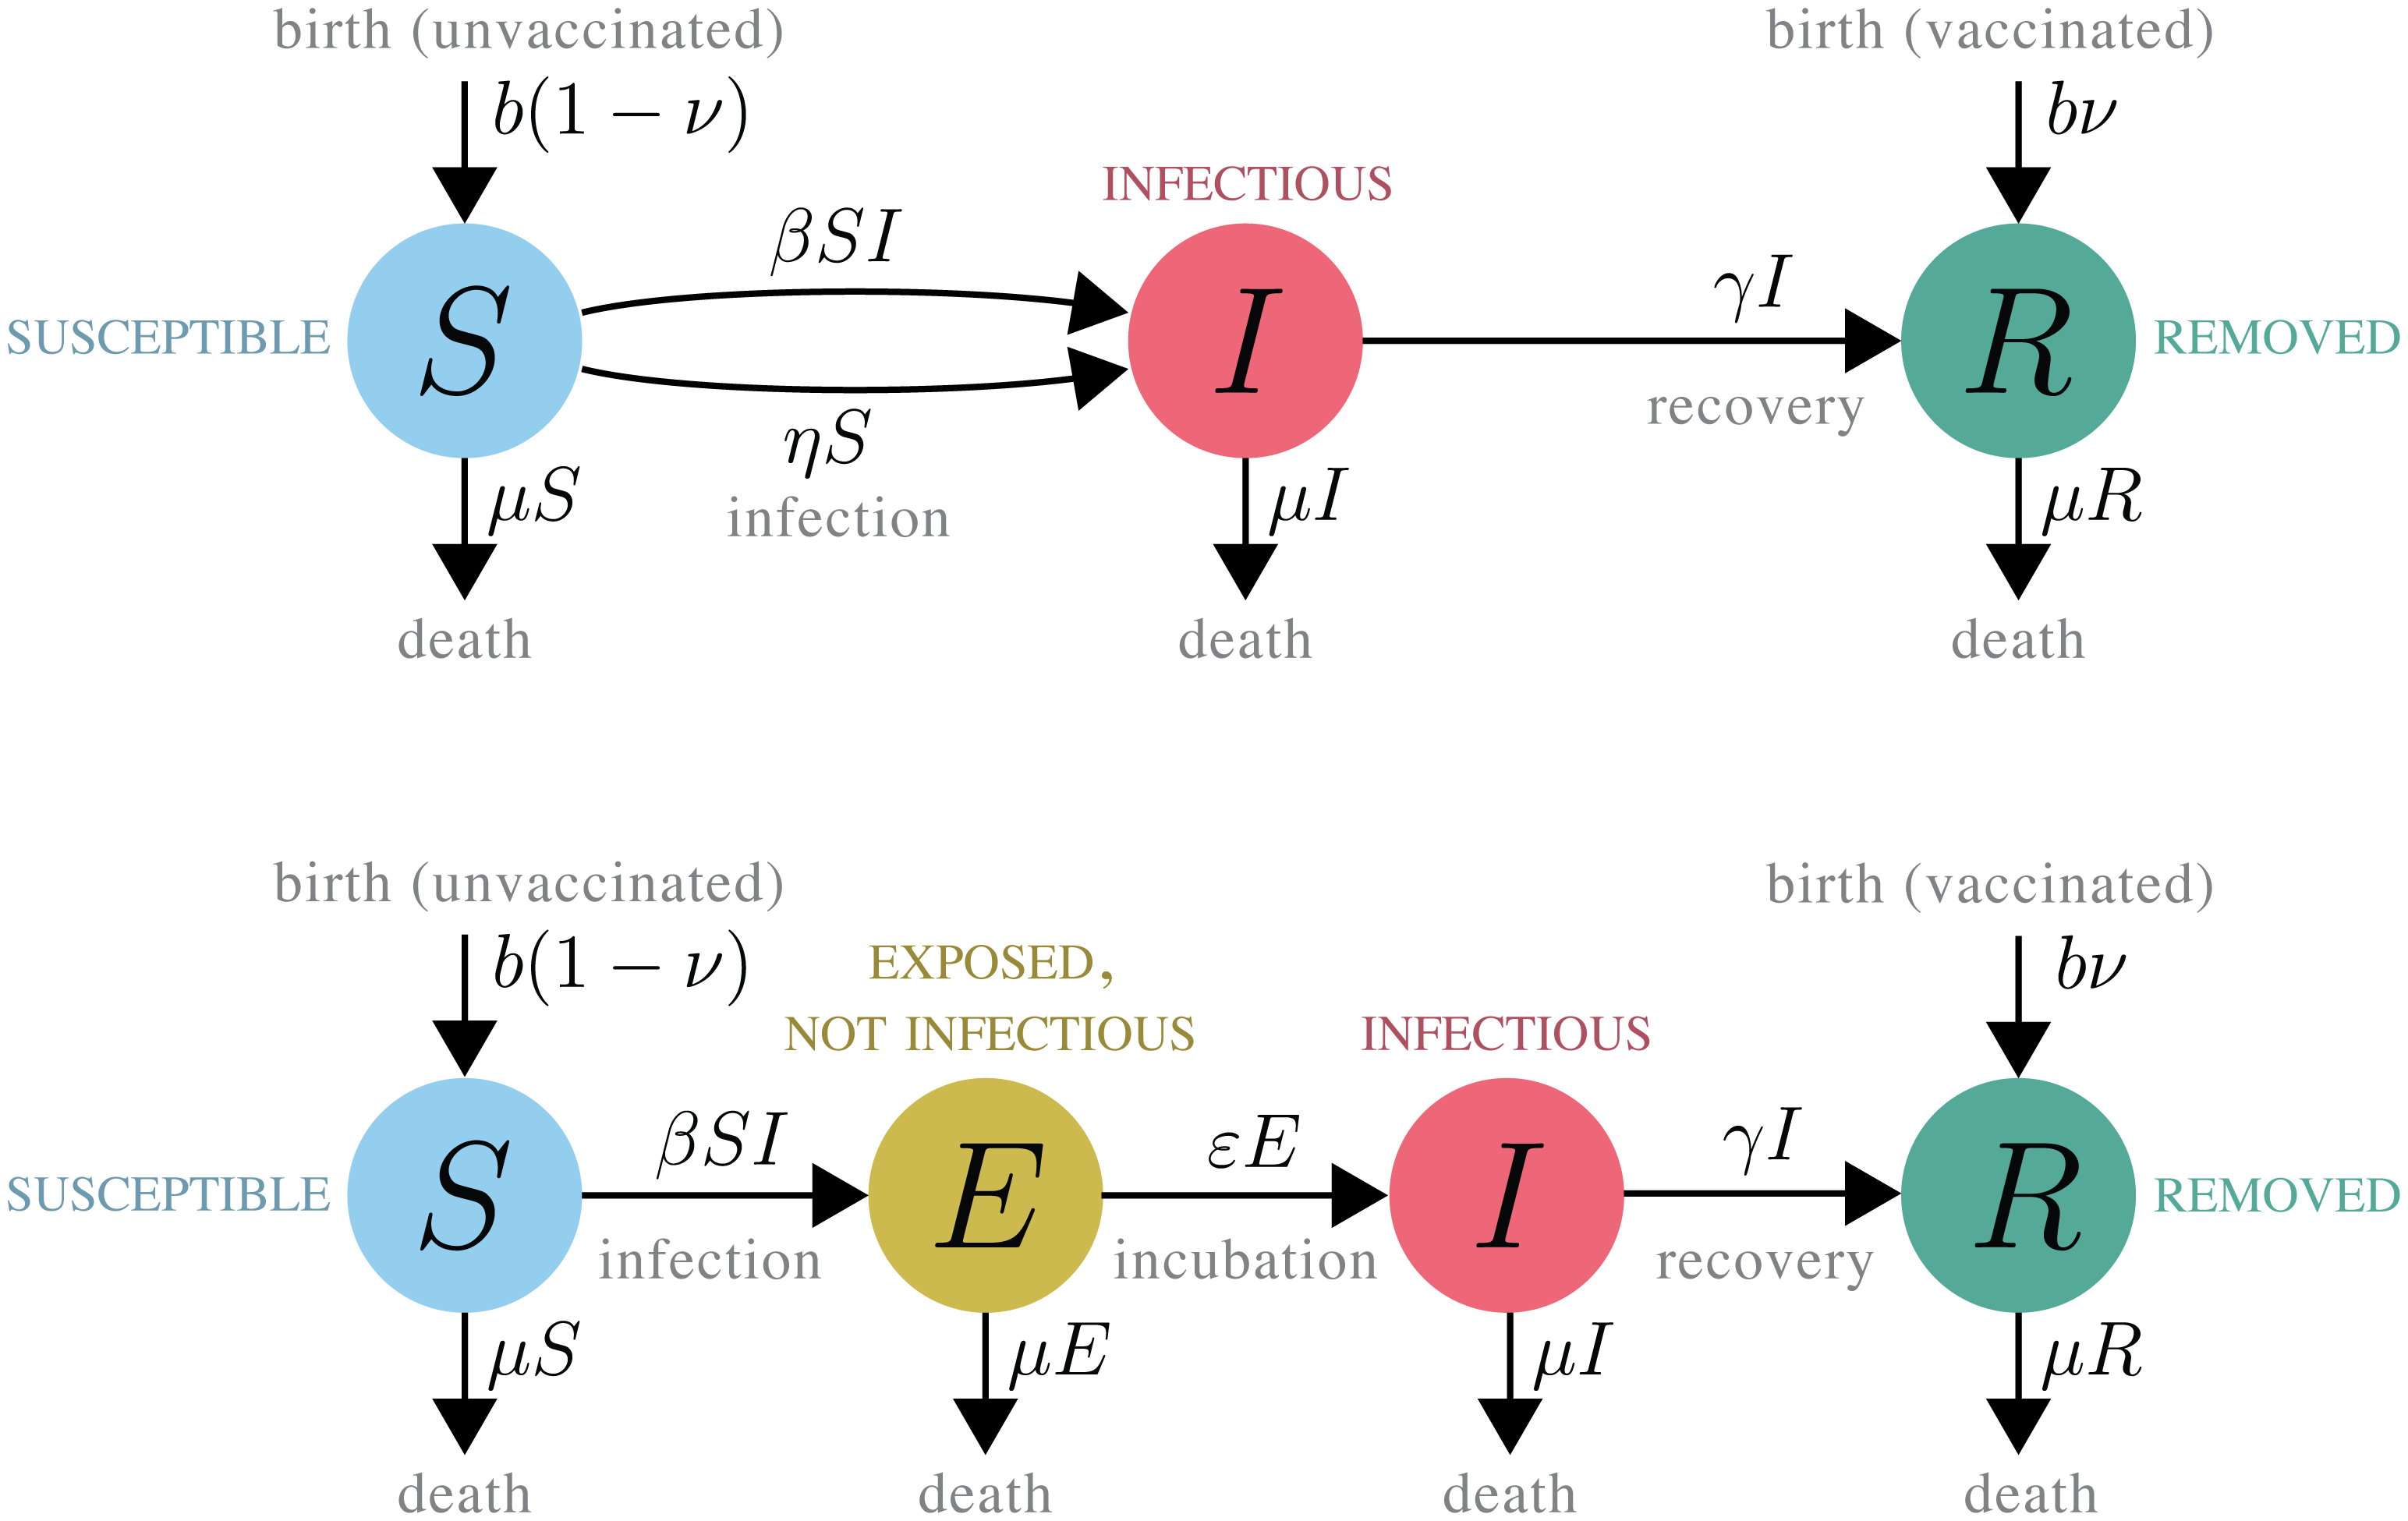

* β - a parameter controlling how much the disease can be transmitted through exposure
* γ - a parameter expressing how much the disease can be recovered in a specific period
* D - the average days to recover from infectious
* R0 - parameter to express the nature of the disease

In [116]:
#Arranging the data set as needed for the SIR model

df_train_pop.head(5)

Id Province_State Country_Region       Date  ConfirmedCases  Fatalities  \
0   1           None    Afghanistan 2020-01-22             0.0         0.0   
1   2           None    Afghanistan 2020-01-23             0.0         0.0   
2   3           None    Afghanistan 2020-01-24             0.0         0.0   
3   4           None    Afghanistan 2020-01-25             0.0         0.0   
4   5           None    Afghanistan 2020-01-26             0.0         0.0   

   Day_num  Day  Month  Year Province.State Country.Region  Population  
0        0   22      1  2020           None    Afghanistan    35530000  
1        1   23      1  2020           None    Afghanistan    35530000  
2        2   24      1  2020           None    Afghanistan    35530000  
3        3   25      1  2020           None    Afghanistan    35530000  
4        4   26      1  2020           None    Afghanistan    35530000

In [117]:
df_fin_selc = df_train_pop[['Province_State','Country_Region','Date','ConfirmedCases','Fatalities','Day_num','Day','Month','Year','Population']]

In [118]:
df_fin_selc[df_fin_selc['Date']=='2020-03-25'].head(5)

Province_State Country_Region       Date  ConfirmedCases  Fatalities  \
63            None    Afghanistan 2020-03-25            84.0         2.0   
133           None        Albania 2020-03-25           146.0         5.0   
203           None        Algeria 2020-03-25           302.0        21.0   
273           None        Andorra 2020-03-25           188.0         1.0   
343           None         Angola 2020-03-25             3.0         0.0   

     Day_num  Day  Month  Year  Population  
63        63   25      3  2020    35530000  
133       63   25      3  2020     2877000  
203       63   25      3  2020    41320000  
273       63   25      3  2020       78000  
343       63   25      3  2020    29780000

In [119]:
df_fin_selc['I'] = df_fin_selc['ConfirmedCases']-df_fin_selc['Fatalities']
df_fin_selc['R'] = df_fin_selc['Fatalities']
df_fin_selc['S'] = df_fin_selc['Population']-df_fin_selc['ConfirmedCases']
df_SIR = df_fin_selc[['Province_State','Country_Region','Population','Day_num','S','I','R']].reindex()
df_SIR[df_SIR['Country_Region'] == 'Italy'].tail(5)

Province_State Country_Region  Population  Day_num           S        I  \
10285           None          Italy    60480000       65  60393502.0  77364.0   
10286           None          Italy    60480000       66  60387528.0  82449.0   
10287           None          Italy    60480000       67  60382311.0  86910.0   
10288           None          Italy    60480000       68  60378261.0  90148.0   
10289           None          Italy    60480000       69  60374208.0  93364.0   

             R  
10285   9134.0  
10286  10023.0  
10287  10779.0  
10288  11591.0  
10289  12428.0

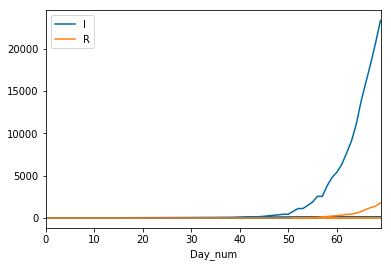

In [120]:
df_SIR[df_SIR['Country_Region']=='United Kingdom'].plot(x='Day_num',y= ['I','R'],kind = 'line')

Classmethod and staticmethod :
[https://stackoverflow.com/questions/136097/difference-between-staticmethod-and-classmethod](http://)

In [121]:
import numpy as np
from scipy.integrate import odeint
from scipy import integrate, optimize

In [122]:
def SIR_testmodel(y,t,bta,gmma):
    S, I, R = y
    
    dS_dt = -1*bta*I*S/N
    dI_dt = (bta*I*S/N) - gmma*I
    dR_dt = gmma*I
    
    return ([dS_dt, dI_dt, dR_dt])

In [123]:
#defining initial conditions

N = 1
S00 = 0.9
I00 = 0.1
R00 = 0.0
bta = 0.35
gmma = 0.1

t = np.linspace(0,100,1000)

sol = odeint(SIR_testmodel,[S00,I00,R00],t,args = (bta,gmma))
sol = np.array(sol)

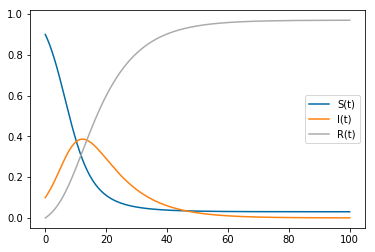

In [124]:
#plotting results

plt.figure(figsize=(6,4))
plt.plot(t, sol[:,0],label = "S(t)")
plt.plot(t, sol[:,1],label = "I(t)")
plt.plot(t, sol[:,2],label = "R(t)")
plt.legend()
plt.show()

### Fitting the SIR model with real data

### Italy

In [125]:
Italy_SIR_df = df_SIR[df_SIR['Country_Region']=='Italy']
#covid_pop_sel[covid_pop_sel['Country.Region']=='Italy']
Italy_SIR_df = Italy_SIR_df.reset_index(drop = True)
Italy_SIR_df.tail(5)

Province_State Country_Region  Population  Day_num           S        I  \
65           None          Italy    60480000       65  60393502.0  77364.0   
66           None          Italy    60480000       66  60387528.0  82449.0   
67           None          Italy    60480000       67  60382311.0  86910.0   
68           None          Italy    60480000       68  60378261.0  90148.0   
69           None          Italy    60480000       69  60374208.0  93364.0   

          R  
65   9134.0  
66  10023.0  
67  10779.0  
68  11591.0  
69  12428.0

In [126]:
display(covid_pop_sel[covid_pop_sel['Country.Region']=='Italy'])

Province.State Country.Region  Population
158           None          Italy    60480000

In [127]:
Country_Dates[Country_Dates['Country_Region'] == 'Italy']

Country_Region fst_Confirmed last_Confirmed   fst_Fatal  last_Fatal  \
84          Italy    2020-01-31     2020-04-13  2020-02-21  2020-04-13   

    Fatality_Days  
84           52.0

In [128]:
cond1 = Italy_SIR_df.I >= 1
test = Italy_SIR_df['Day_num'][(cond1)]
test
Italy_SIR_df.iloc[:10]

Province_State Country_Region  Population  Day_num           S    I    R
0           None          Italy    60480000        0  60480000.0  0.0  0.0
1           None          Italy    60480000        1  60480000.0  0.0  0.0
2           None          Italy    60480000        2  60480000.0  0.0  0.0
3           None          Italy    60480000        3  60480000.0  0.0  0.0
4           None          Italy    60480000        4  60480000.0  0.0  0.0
5           None          Italy    60480000        5  60480000.0  0.0  0.0
6           None          Italy    60480000        6  60480000.0  0.0  0.0
7           None          Italy    60480000        7  60480000.0  0.0  0.0
8           None          Italy    60480000        8  60480000.0  0.0  0.0
9           None          Italy    60480000        9  60479998.0  2.0  0.0

In [129]:
Italy_S = Italy_SIR_df['S']
Italy_I = Italy_SIR_df['I']
Italy_R = Italy_SIR_df['R']

Italy_s = np.array(Italy_S, dtype=float)
Italy_i = np.array(Italy_I, dtype=float)
Italy_r = np.array(Italy_R, dtype=float)

display(Italy_s[9],Italy_i[9], Italy_r[9])

60479998.0

2.0

0.0

In [130]:
def SIR_model(y,t,beta,gamma):
    S, I, R = y
    N = 60480000
    dS_dt = -1*beta*I*S/N
    dI_dt = (beta*I*S/N) - gamma*I
    dR_dt = gamma*I
    
    return ([dS_dt, dI_dt, dR_dt])

def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

In [131]:
xdata = Italy_SIR_df.Day_num
ydata = Italy_i
xdata = np.array(xdata, dtype=float)

S0 = 60479998.0
I0 = 2.0
R0 = 0
y = S0, I0, R0

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

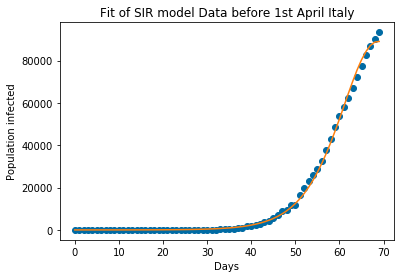

Optimal parameters: beta = 3.277804672334483  and gamma =  3.1015313178785435


In [132]:
plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model, Data before 1st April, Italy")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

### Italy - Using the updated data set with Recovered Count

In [133]:
#I am using the new data set with Recovered details included as I am getting gamma and beta values more than 1
#this is the same above data set with more details incorporated like Recovered Count and longutude latitude details

comp_df = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
comp_df.head(5)

Province/State Country/Region      Lat     Long     Date  Confirmed  Deaths  \
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0       0   
1            NaN        Albania  41.1533  20.1683  1/22/20          0       0   
2            NaN        Algeria  28.0339   1.6596  1/22/20          0       0   
3            NaN        Andorra  42.5063   1.5218  1/22/20          0       0   
4            NaN         Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [134]:
comp_df['Province/State'].fillna("None", inplace=True)

#Checking null values
comp_df[comp_df.iloc[:,0:].isnull().any(axis = 1)].iloc[:,0:].head()

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, Date, Confirmed, Deaths, Recovered]
Index: []

In [135]:
comp_df['Date'] = pd.to_datetime(comp_df['Date'])

In [136]:
#covid_pop_sel 
covid_pop_sel.loc[covid_pop_sel['Country.Region']=='Korea, South', 'Country.Region'] = 'South Korea'
comp_df_pop = comp_df.merge(covid_pop_sel, left_on = ['Country/Region','Province/State'], right_on = ['Country.Region','Province.State'], how = 'left')
comp_df_pop.tail(3)

Province/State         Country/Region        Lat       Long       Date  \
21481           None         Western Sahara  24.215500 -12.885800 2020-04-12   
21482           None  Sao Tome and Principe   0.186360   6.613081 2020-04-12   
21483           None                  Yemen  15.552727  48.516388 2020-04-12   

       Confirmed  Deaths  Recovered Province.State         Country.Region  \
21481          6       0          0           None         Western Sahara   
21482          4       0          0           None  Sao Tome and Principe   
21483          1       0          0            NaN                    NaN   

       Population  
21481    593611.0  
21482    218152.0  
21483         NaN

In [137]:
comp_pop_sel = comp_df_pop[['Province/State','Country/Region','Date','Confirmed','Deaths','Recovered','Population']]

In [138]:
comp_pop_sel['Country/Region'][comp_pop_sel['Population'].isnull()].unique()

array(['Canada', 'Yemen'], dtype=object)

In [139]:
#comp_df[comp_df['Country/Region'].str.match('Canada')]
#covid_pop_sel[covid_pop_sel['Country.Region'].str.match('Canada')].head(2)

In [140]:
missings_count = {col:comp_pop_sel[col].isnull().sum() for col in comp_pop_sel.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                  0
Population      164
Province/State    0
Country/Region    0
Date              0
Confirmed         0
Deaths            0
Recovered         0


In [141]:
#treating null values
comp_pop_sel['Population'] = comp_pop_sel['Population'].fillna(0)

In [142]:
comp_df_Italy = comp_pop_sel[comp_pop_sel['Country/Region']=='Italy']
comp_df_Italy = comp_df_Italy.reset_index(drop = True)
comp_df_Italy.tail(5)

Province/State Country/Region       Date  Confirmed  Deaths  Recovered  \
77           None          Italy 2020-04-08     139422   17669      26491   
78           None          Italy 2020-04-09     143626   18279      28470   
79           None          Italy 2020-04-10     147577   18849      30455   
80           None          Italy 2020-04-11     152271   19468      32534   
81           None          Italy 2020-04-12     156363   19899      34211   

    Population  
77  60480000.0  
78  60480000.0  
79  60480000.0  
80  60480000.0  
81  60480000.0

In [143]:
comp_df_Italy['Day_num'] = preprocessing.LabelEncoder().fit_transform(comp_df_Italy.Date)
comp_df_Italy.tail(3)

Province/State Country/Region       Date  Confirmed  Deaths  Recovered  \
79           None          Italy 2020-04-10     147577   18849      30455   
80           None          Italy 2020-04-11     152271   19468      32534   
81           None          Italy 2020-04-12     156363   19899      34211   

    Population  Day_num  
79  60480000.0       79  
80  60480000.0       80  
81  60480000.0       81

In [144]:
comp_df_Italy['R'] = comp_df_Italy['Deaths']+comp_df_Italy['Recovered']
comp_df_Italy['I'] = comp_df_Italy['Confirmed']- comp_df_Italy['R']
comp_df_Italy['S'] = comp_df_Italy['Population']-comp_df_Italy['I']-comp_df_Italy['R']
comp_df_Italy.tail(3)

Province/State Country/Region       Date  Confirmed  Deaths  Recovered  \
79           None          Italy 2020-04-10     147577   18849      30455   
80           None          Italy 2020-04-11     152271   19468      32534   
81           None          Italy 2020-04-12     156363   19899      34211   

    Population  Day_num      R       I           S  
79  60480000.0       79  49304   98273  60332423.0  
80  60480000.0       80  52002  100269  60327729.0  
81  60480000.0       81  54110  102253  60323637.0

In [145]:
comp_df_Italy_S = comp_df_Italy['S']
comp_df_Italy_I = comp_df_Italy['I']
comp_df_Italy_R = comp_df_Italy['R']

comp_df_Italy_s = np.array(comp_df_Italy_S, dtype=float)
comp_df_Italy_i = np.array(comp_df_Italy_I, dtype=float)
comp_df_Italy_r = np.array(comp_df_Italy_R, dtype=float)

display(comp_df_Italy_s[9],comp_df_Italy_i[9], comp_df_Italy_r[9])

60479998.0

2.0

0.0

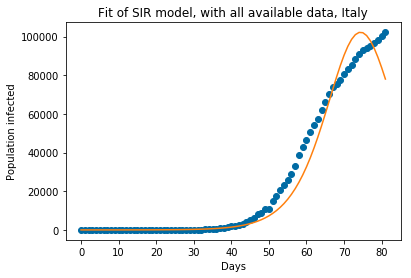

Optimal parameters: beta = 2.8612843065502664  and gamma =  2.696513508939297


In [146]:
N = 60480000
S0 = 60479998
I0 = 2
R0 = 0

xdata = comp_df_Italy.Day_num
xdata = np.array(xdata, dtype=float)
ydata = comp_df_Italy_i
ydata = np.array(ydata, dtype=float)

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model, with all available data, Italy")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

Insight : Althougth the curve is fitting for data before April 1, the curve is not fitting to data after April 1st. So I am going to try XGBOOST classifier for this. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

### Trying with XGBoost Algorithm

In [147]:
df_train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')
df_test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')
df_subm = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/submission.csv')

In [148]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [149]:
df_train.rename(columns={'Country_Region':'Country'}, inplace=True)
df_train.rename(columns={'Province_State':'State'}, inplace=True)
df_train['Date'] = pd.to_datetime(df_train['Date'], infer_datetime_format=True)

df_test.rename(columns={'Country_Region':'Country'}, inplace=True)
df_test.rename(columns={'Province_State':'State'}, inplace=True)
df_test['Date'] = pd.to_datetime(df_test['Date'], infer_datetime_format=True)

In [150]:
#confirmed cases
y1_df_Train = df_train.iloc[:, -2]
#fatalities
y2_df_Train = df_train.iloc[:, -1]

NOVAL = "NOVAL"
def handlenullstate(State, Country):
    if State == NOVAL: return Country
    return State

In [151]:
#Data Cleansing and enrichment

df_train['State'].fillna(NOVAL, inplace=True)
df_train['State'] = df_train.loc[:, ['State', 'Country']].apply(lambda x : handlenullstate(x['State'], x['Country']), axis=1)

df_train.loc[:, 'Date'] = df_train.Date.dt.strftime("%m%d")
df_train["Date"]  = df_train["Date"].astype(int)

df_test['State'].fillna(NOVAL, inplace=True)
df_test['State'] = df_test.loc[:, ['State', 'Country']].apply(lambda x : handlenullstate(x['State'], x['Country']), axis=1)

df_test.loc[:, 'Date'] = df_test.Date.dt.strftime("%m%d")
df_test["Date"]  = df_test["Date"].astype(int)

df_test.head()

ForecastId        State      Country  Date
0           1  Afghanistan  Afghanistan   402
1           2  Afghanistan  Afghanistan   403
2           3  Afghanistan  Afghanistan   404
3           4  Afghanistan  Afghanistan   405
4           5  Afghanistan  Afghanistan   406

In [152]:
covid_pop_taken = covid_pop[['Province.State','Country.Region','Population']]

In [153]:
covid_pop_taken.rename(columns={'Province.State':'State'}, inplace=True)
covid_pop_taken.rename(columns={'Country.Region':'Country'}, inplace=True)

In [154]:
covid_pop_taken['State'].fillna("None", inplace=True)
NOVAL = 'None'
covid_pop_taken['State'] = covid_pop_taken.loc[:, ['State', 'Country']].apply(lambda x : handlenullstate(x['State'], x['Country']), axis=1)
covid_pop_taken.head(3)

State      Country  Population
0  Afghanistan  Afghanistan    35530000
1      Albania      Albania     2877000
2      Algeria      Algeria    41320000

In [155]:
df_train_copy2 = df_train.copy()
df_test_copy2 = df_test.copy()
df_test.head(3)

ForecastId        State      Country  Date
0           1  Afghanistan  Afghanistan   402
1           2  Afghanistan  Afghanistan   403
2           3  Afghanistan  Afghanistan   404

In [156]:
df_train_co_pop = df_train.merge(covid_pop_taken, left_on = ['Country','State'], right_on = ['Country','State'], how = 'left')
df_test_co_pop = df_test.merge(covid_pop_taken, left_on = ['Country','State'], right_on = ['Country','State'], how = 'left')
df_test_co_pop.head(5)

ForecastId        State      Country  Date  Population
0           1  Afghanistan  Afghanistan   402    35530000
1           2  Afghanistan  Afghanistan   403    35530000
2           3  Afghanistan  Afghanistan   404    35530000
3           4  Afghanistan  Afghanistan   405    35530000
4           5  Afghanistan  Afghanistan   406    35530000

In [157]:
df_train_co_pop['Country'][df_train_co_pop['Population'].isnull()].unique()

array([], dtype=object)

In [158]:
#covid_pop_sel.loc[covid_pop_sel['Country']=='Korea, South', 'Country.Region'] = 'South Korea'

#### Preprocessing

In [159]:
df_train_co_pop[['Population']] = preprocessing.scale(df_train_co_pop[['Population']])
df_test_co_pop[['Population']] = preprocessing.scale(df_test_co_pop[['Population']])

In [160]:
df_train_co_pop.head(3)

Id        State      Country  Date  ConfirmedCases  Fatalities  Population
0   1  Afghanistan  Afghanistan   122             0.0         0.0    0.144425
1   2  Afghanistan  Afghanistan   123             0.0         0.0    0.144425
2   3  Afghanistan  Afghanistan   124             0.0         0.0    0.144425

In [161]:
df_train = df_train_co_pop 
df_test = df_test_co_pop 

In [162]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df_train.Country = le.fit_transform(df_train.Country)
df_train['State'] = le.fit_transform(df_train['State'])
df_train.Country = le.fit_transform(df_train.Country)

df_test.Country = le.fit_transform(df_test.Country)
df_test['State'] = le.fit_transform(df_test['State'])

df_test.head()

ForecastId  State  Country  Date  Population
0           1      0        0   402    0.144425
1           2      0        0   403    0.144425
2           3      0        0   404    0.144425
3           4      0        0   405    0.144425
4           5      0        0   406    0.144425

In [163]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

from xgboost import XGBRegressor

countries = df_train.Country.unique()

In [164]:
xout = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = df_train.loc[df_train.Country == country, :].State.unique()
    for state in states:
        #trian
        x_train_CS = df_train.loc[(df_train.Country == country) & (df_train.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities','Population']]
        y1_train_CS = x_train_CS.loc[:, 'ConfirmedCases']
        y2_train_CS = x_train_CS.loc[:, 'Fatalities']
        x_train_CS = x_train_CS.loc[:, ['State', 'Country', 'Date','Population']]
        x_train_CS.Country = le.fit_transform(x_train_CS.Country)
        x_train_CS['State'] = le.fit_transform(x_train_CS['State'])
        
        #test
        x_test_CS = df_test.loc[(df_test.Country == country) & (df_test.State == state), ['State', 'Country', 'Date', 'ForecastId','Population']]
        x_test_CS_Id = x_test_CS.loc[:, 'ForecastId']
        x_test_CS = x_test_CS.loc[:, ['State', 'Country', 'Date','Population']]
        x_test_CS.Country = le.fit_transform(x_test_CS.Country)
        x_test_CS['State'] = le.fit_transform(x_test_CS['State'])
        
        xmodel1 = XGBRegressor(n_estimators=1000)
        xmodel1.fit(x_train_CS, y1_train_CS)
        y1_xpred = xmodel1.predict(x_test_CS)
        
        xmodel2 = XGBRegressor(n_estimators=1000)
        xmodel2.fit(x_train_CS, y2_train_CS)
        y2_xpred = xmodel2.predict(x_test_CS)
        
        xdata = pd.DataFrame({'ForecastId': x_test_CS_Id, 'ConfirmedCases': y1_xpred, 'Fatalities': y2_xpred})
        xout = pd.concat([xout, xdata], axis=0)


In [165]:
xout.ForecastId = xout.ForecastId.astype('int')
xout['ConfirmedCases'] = round(xout['ConfirmedCases'],1)
xout['Fatalities'] = round(xout['Fatalities'],1)
display(xout.head())

ForecastId  ConfirmedCases  Fatalities
0           1           273.0         6.0
1           2           281.0         6.0
2           3           299.0         7.0
3           4           349.0         7.0
4           5           367.0        11.0

In [166]:
#xout['ForecastId'] = xout['ForecastId'].apply(int)
xout['ConfirmedCases'] = xout['ConfirmedCases'].apply(int)
xout['Fatalities'] = xout['Fatalities'].apply(int)

In [167]:
xout.dtypes

ForecastId        int64
ConfirmedCases    int64
Fatalities        int64
dtype: object

In [168]:
xout = xout.drop_duplicates()
xout.reindex()

ForecastId  ConfirmedCases  Fatalities
0               1             273           6
1               2             281           6
2               3             299           7
3               4             349           7
4               5             367          11
...           ...             ...         ...
13626       13455              17           3
13627       13456              17           3
13628       13457              17           3
13629       13458              17           3
13630       13459              17           3

[13459 rows x 3 columns]

In [169]:
xout.to_csv('submission.csv', index=False)